#### Libraries

In [1]:
import copy, time
import random
import pdb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [2]:
from distributions import VonMisesFisher, HypersphericalUniform

In [3]:
from IPython import display
matplotlib.rcParams['figure.figsize'] = [12,8]

#### Generic Utils 

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value. 
       Also stores a rolling average of size roll_len."""
    def __init__(self, roll_len=100):
        self.reset()
        self.roll_len = roll_len
        self.roll = []

    def reset(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0; self.roll = []; self.roll_avg = 0

    def update(self, val, n=1):
        self.val = val; self.sum += val * n; self.count += n
        self.avg = self.sum / self.count
        self.roll = (self.roll + [val] * n)[-self.roll_len:]
        self.roll_avg = sum(self.roll) / len(self.roll)
        
def check(val, msg):
    '''Checks whether val is nan or inf and prints msg if True'''
    if (val * 0 != 0): print(msg); pdb.set_trace()
        
def to_numpy(t):
    '''PyTorch tensor to numpy array'''
    return t.detach().to('cpu').numpy()

#### Data 

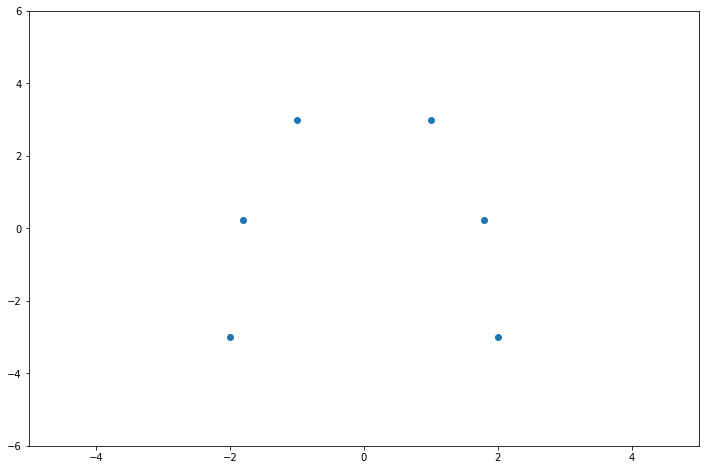

In [49]:
# Reproducibility
torch.manual_seed(20)

# Synthetic dataset
DATASET = 'class' # 'class' or 'cubic' or 'bakeoff'

if DATASET == 'class': # size points from class
    X_train = torch.tensor([-2.0,-1.8,-1.0,1,1.8,2]).reshape(-1,1)
    Y_true  = - X_train**4 + 3*X_train**2 + 1
    Y_noise = 0
    Y_train = Y_true + Y_noise
    X_range = torch.arange(-5,5,0.05).reshape(-1,1)
    plt.axis([-5,5,-6,6])
elif DATASET == 'cubic': # from multiple papers
    X_train = (torch.rand(20,1) - 0.5) * 8
    Y_true  = X_train**3 
    Y_noise = torch.randn(20,1) * 3.0
    Y_train = Y_true + Y_noise
    X_range = torch.arange(-5,5,0.05).reshape(-1,1)
    plt.axis([-6,6,-100,100])
elif DATASET == 'bakeoff': # from the bakeoff paper
    # https://pdfs.semanticscholar.org/6197/dbd691037a412b67df688541df7c9ae87c0d.pdf
    N = 50
    X_train = (torch.randn(N,1) * 2).clamp(-4,4)
    Y_true  = (1 + X_train) * torch.sin(10 * torch.tanh(X_train))
    Y_noise = torch.randn(N,1) * 0.2
    Y_train = Y_true + Y_noise
    X_range = torch.arange(-6,6,0.01).reshape(-1,1)
    plt.axis([-6,6,-4,3])
    
# Plot dataset
plt.scatter(to_numpy(X_train), to_numpy(Y_true))
plt.show()

#### Model

In [76]:
class HypersphericalNet(nn.Module):
    def __init__(self):
        super(HypersphericalNet, self).__init__()
        # For now there is no flexibility. It is a 1 layer net with 6 parameters. 
        
        # Means
        self.w1_m = nn.Parameter(torch.zeros(1, DIM))
        self.b1_m = nn.Parameter(torch.zeros(1, DIM)) 
        self.w2_m = nn.Parameter(torch.zeros(1, DIM)) 
        self.b2_m = nn.Parameter(torch.zeros(1,   1)) 
        # self.w1_m = torch.zeros(1,DIM, requires_grad=True)
        # self.b1_m = torch.zeros(1,DIM, requires_grad=True)
        # self.w2_m = torch.zeros(DIM,1, requires_grad=True)
        # self.b2_m = torch.zeros(1,1, requires_grad=True)
        
        # (Softplus) standard deviations
        self.w1_s = nn.Parameter(torch.zeros(1, 1))
        self.b1_s = nn.Parameter(torch.zeros(1, 1))
        self.w2_s = nn.Parameter(torch.zeros(1, 1))
        self.b2_s = nn.Parameter(torch.zeros(1, 1))
        # self.w1_s = torch.zeros(  1,DIM, requires_grad=True)
        # self.b1_s = torch.zeros(  1,DIM, requires_grad=True)
        # self.w2_s = torch.zeros(DIM,  1, requires_grad=True)
        # self.b2_s = torch.zeros(  1,  1, requires_grad=True)
                
        # Initialize
        self.init_weights_()
    
    def init_weights_(self):
        for m in [self.w1_m, self.b1_m, self.w2_m, self.b2_m]:
            m.data.normal_(0,1)
            m.data = m.data / m.data.norm()
        for m in [self.w1_s, self.b1_s, self.w2_s, self.b2_s]:
            m.data.uniform_(0,0.25)

    def get_params(self):
        return self.w1_m, self.b1_m, self.w2_m, self.b2_m, self.w1_s, self.b1_s, self.w2_s, self.b2_s
    
    def get_tensor_form(self):
        '''A hack to get around the fact that nn.Parameter cannot be an input 
           to a PyTorch distribution in version 0.4.1'''
        return (self.w1_m * torch.ones(1),
                self.b1_m * torch.ones(1),
                self.w2_m * torch.ones(1),
                self.b2_m * torch.ones(1),
                F.softplus(self.w1_s * torch.ones(1)),
                F.softplus(self.b1_s * torch.ones(1)),
                F.softplus(self.w2_s * torch.ones(1)),
                F.softplus(self.b2_s * torch.ones(1)))
    
    def sample_weights(self):
        
        # Get weights as tensors, not parameters
        w1_m, b1_m, w2_m, b2_m, w1_s, b1_s, w2_s, b2_s = self.get_tensor_form()
        
        # Renormalize weights
        w1_m = self.w1_m / self.w1_m.norm()
        b1_m = self.b1_m / self.b1_m.norm()
        w2_m = self.w2_m / self.w2_m.norm()
        
        # Sample
        w1 = w1_m # VonMisesFisher(w1_m, w1_s).rsample().reshape(1,DIM)
        b1 = b1_m # VonMisesFisher(b1_m, b1_s).rsample().reshape(1,DIM)
        w2 = w2_m # VonMisesFisher(w2_m, w2_s).rsample().reshape(1,DIM)
        b2 = b2_m # Normal(        b2_m, b2_s).rsample()
        
        # # Sample
        # w1 = Normal(self.w1_m, F.softplus(self.w1_s)).rsample()
        # b1 = Normal(self.b1_m, F.softplus(self.b1_s)).rsample()
        # w2 = Normal(self.w2_m, F.softplus(self.w2_s)).rsample()
        # b2 = Normal(self.b2_m, F.softplus(self.b2_s)).rsample()
        
        return w1, b1, w2, b2
    
    def get_log_p(self, sample, prior_std=1.0):
        w1, b1, w2, b2 = sample
        
        # Get log prior (constants)
        log_p_w1 = HypersphericalUniform(DIM-1).log_prob(w1).sum()
        log_p_b1 = HypersphericalUniform(DIM-1).log_prob(b1).sum()
        log_p_w2 = HypersphericalUniform(DIM-1).log_prob(w2).sum()
        log_p_b2 = Normal(torch.zeros(  1), torch.ones(  1)*prior_std).log_prob(b2).sum()
        
        # log_p_w1 = Normal(torch.zeros(DIM), torch.ones(DIM)*prior_std).log_prob(w1).sum()
        # log_p_b1 = Normal(torch.zeros(DIM), torch.ones(DIM)*prior_std).log_prob(b1).sum()
        # log_p_w2 = Normal(torch.zeros(DIM), torch.ones(DIM)*prior_std).log_prob(w2).sum()
        # log_p_b2 = Normal(torch.zeros(  1), torch.ones(  1)*prior_std).log_prob(b2).sum()
        
        return log_p_w1 + log_p_b1 + log_p_w2 + log_p_b2
    
    def get_log_q(self, sample):
        w1, b1, w2, b2 = sample
        
        # Get weights as tensors, not parameters
        w1_m, b1_m, w2_m, b2_m, w1_s, b1_s, w2_s, b2_s = self.get_tensor_form()
        
        # Get log q(z)
        log_q_w1 = VonMisesFisher(w1_m, w1_s).log_prob(w1).sum()
        log_q_b1 = VonMisesFisher(b1_m, b1_s).log_prob(b1).sum()
        log_q_w2 = VonMisesFisher(w2_m, w2_s).log_prob(w2).sum()
        log_q_b2 = Normal(        b2_m, b2_s).log_prob(b2).sum()
        
        # log_q_w1 = Normal(self.w1_m, F.softplus(self.w1_s)).log_prob(w1).sum()
        # log_q_b1 = Normal(self.b1_m, F.softplus(self.b1_s)).log_prob(b1).sum()
        # log_q_w2 = Normal(self.w2_m, F.softplus(self.w2_s)).log_prob(w2).sum()
        # log_q_b2 = Normal(self.b2_m, F.softplus(self.b2_s)).log_prob(b2).sum()
        
        return log_q_w1 + log_q_b1 + log_q_w2 + log_q_b2
        
    def forward(self, x, sample, nonlinearity='rbf'):
        '''Unroll network and forward pass'''
        w1, b1, w2, b2 = sample
        w1, b1, w2, b2 = w1.reshape(1,DIM), b1.reshape(1,DIM), w2.reshape(DIM,1), b2.reshape(1,1)
        
        x = x @ w1 + b1
        x = nn.functional.relu(x) if nonlinearity=='relu' else torch.exp(-x*x)
        x = x @ w2 + b2 
        return x
    
    def fwd_not_bayes(self, x):
        x = x @ self.w1_m + self.b1_m
        x = torch.exp(-x*x)
        x = x @ self.w2_m.reshape(DIM,1) + self.b2_m 
        return x

In [89]:
def BBB(x, y, model, optimizer, num_samples=1, epochs=int(1e5), 
        noise_std=0.1, seed=None, print_every=500):
    '''Performs black-box variational inference'''
    torch.manual_seed(seed if seed else random.randint(0,1000))
        
    # Track ELBO statistics
    elbo_meter = AverageMeter(100)
    elbo_hist = []
        
    for ix_e in range(epochs):
        gradients = [torch.zeros_like(x) for x in model.get_params()]
        for ix_s in range(num_samples):
            
            # Sample weights
            sample = model.sample_weights()
            
            # Likelihood
            y_hat = model.forward(x, sample)
            log_l = Normal(y_hat.squeeze(), noise_std * torch.ones(x.shape[0])).log_prob(y.squeeze()).sum()
            
            # Regularization
            log_p = model.get_log_p(sample)
            log_q = model.get_log_q(sample)
            
            # ELBO = log likelihood + log p - log q
            elbo = (log_l) # + log_p - log_q).squeeze()
            loss = - elbo / num_samples
            
            # Store gradients
            optimizer.zero_grad()
            loss.backward() # retain_graph=True)
            for x, p in zip(gradients, model.get_params()):
                x += p.grad.data if p.grad is not None else 0
            optimizer.zero_grad()
            
            # Update ELBO statistics
            elbo_meter.update(elbo.item())
            elbo_hist.append(elbo.item())
        
            # Pray
            assert not sum(torch.isnan(x).any() for x in model.get_params())

        # Step gradient:
        optimizer.zero_grad()
        for x, p in zip(gradients, model.get_params()):
            if p.grad is not None:
                p.grad.data = x / num_samples
        optimizer.step()
        
        # Print statistics
        if print_every > 0 and ix_e % print_every == 10: 
            print('{:5d} | ELBO {:6.0f} | Rolling: {:6.0f}'.format(
                ix_e, elbo_meter.avg, elbo_meter.roll_avg))
            
            ## Plot
            #plot_samples(model)

    return model, elbo_meter.roll_avg, elbo_hist

In [90]:
# Hyperparameters
HYPERSPHERICAL = True
DIM = 6

# Take best of many random restarts
best_elbo = -1000
best_hist = None
best_model = None
random_restarts = 20
for _ in range(random_restarts):
    
    # model = HypersphericalNet()
    
    # Optimization
    lr = 1e-10
    optimizer = torch.optim.SGD(model.get_params(), lr=lr)
    
    # Run VI
    model, elbo, hist = BBB(X_train, Y_train, model, optimizer, num_samples=11,
                            print_every=11, epochs=int(5e4))
    
    # Statistics
    display.clear_output()
    if elbo > best_elbo:
        best_elbo = elbo
        best_hist = hist
        best_model = model
        print('---> Model with new best ELBO (lr={:.3f}): {:.2f}'.format(lr, best_elbo))
    else:
        print('     Model with ELBO (lr={:.2f},best={:.2f}): {:.2f}'.format(lr, best_elbo, elbo))

   10 | ELBO  -1944 | Rolling:  -1944
   21 | ELBO  -1944 | Rolling:  -1944
   32 | ELBO  -1944 | Rolling:  -1944
   43 | ELBO  -1944 | Rolling:  -1944
   54 | ELBO  -1944 | Rolling:  -1944
   65 | ELBO  -1944 | Rolling:  -1944
   76 | ELBO  -1944 | Rolling:  -1944
   87 | ELBO  -1944 | Rolling:  -1944
   98 | ELBO  -1944 | Rolling:  -1944
  109 | ELBO  -1944 | Rolling:  -1944
  120 | ELBO  -1944 | Rolling:  -1944
  131 | ELBO  -1944 | Rolling:  -1944
  142 | ELBO  -1944 | Rolling:  -1944
  153 | ELBO  -1944 | Rolling:  -1944
  164 | ELBO  -1944 | Rolling:  -1944
  175 | ELBO  -1944 | Rolling:  -1944
  186 | ELBO  -1944 | Rolling:  -1944


KeyboardInterrupt: 

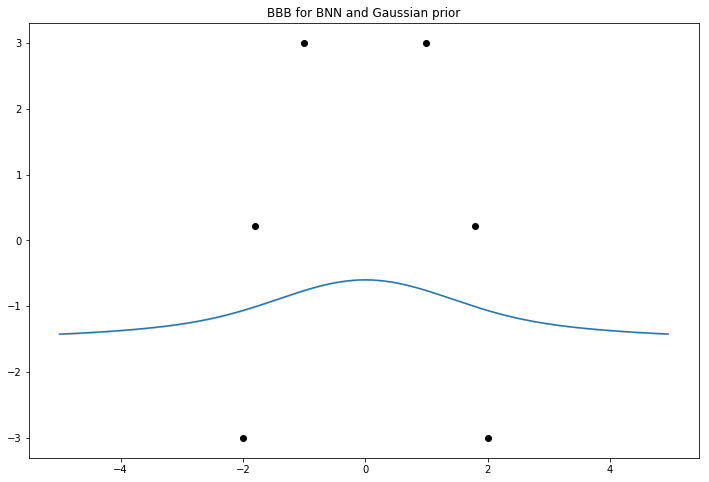

In [80]:
def plot_samples(model, n_samples=100):
    '''Plot samples from '''
    preds = []
    for _ in range(n_samples):
        samples = model.sample_weights()
        pred = model(X_range, samples)
        preds.append(to_numpy(pred))
    preds = np.concatenate(preds, axis=1)
    bound = int(n_samples * 0.05)
    preds_95 = (np.sort(preds, axis=1)[:, bound], np.sort(preds, axis=1)[:,-bound])
    mean = np.mean(preds, axis=1)

    # Plot
    plt.gca().set_title('BBB for BNN and Gaussian prior')
    plt.gca().fill_between(X_range.reshape(-1), preds_95[1], preds_95[0], color="#cccccc")
    plt.scatter(X_train, Y_train, color='black', marker='o')
    plt.plot(to_numpy(X_range), mean)
    plt.show() # plt.axis([-5,5,-8,8])
    
# Sample from distribution over networks
model = best_model if best_model else model
plot_samples(model)

tensor(3351.1724, grad_fn=<NegBackward>)
tensor(1219.1250, grad_fn=<NegBackward>)
tensor(924.8390, grad_fn=<NegBackward>)
tensor(776.6685, grad_fn=<NegBackward>)
tensor(728.1348, grad_fn=<NegBackward>)
tensor(720.8295, grad_fn=<NegBackward>)
tensor(720.3536, grad_fn=<NegBackward>)
tensor(720.3342, grad_fn=<NegBackward>)
tensor(720.3342, grad_fn=<NegBackward>)
tensor(720.3341, grad_fn=<NegBackward>)


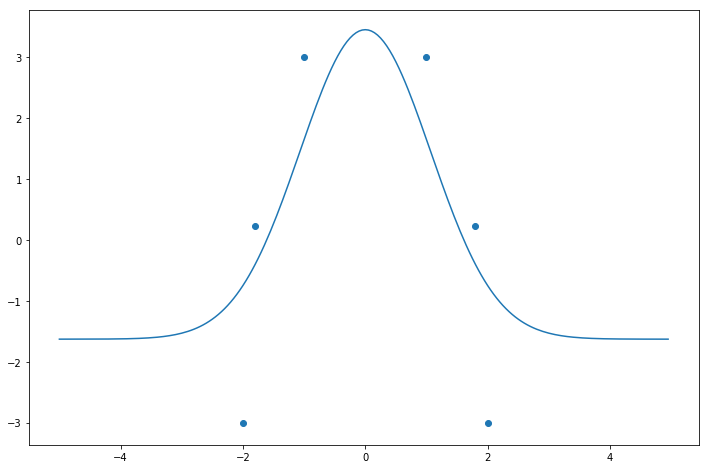

In [93]:
model = HypersphericalNet()
opt = optim.Adam(model.get_params(), lr=1e-3, weight_decay=100)
for i in range(10000):
    # train
    opt.zero_grad()
    out = model.fwd_not_bayes(X_train)
    loss = - Normal(out.squeeze(), 0.1*torch.ones(X_train.shape[0])).log_prob(Y_train.squeeze()).sum()
    loss.backward()
    opt.step()
    if i % 1000 == 0: print(loss)

Y_range = model.fwd_not_bayes(X_range)
plt.plot(to_numpy(X_range), to_numpy(Y_range))
plt.scatter(to_numpy(X_train), to_numpy(Y_train))